# DSI-18 - Capstone Project - Vegetable Classifier (2/2)
This is the 2nd part of my capstone project for DSI-18 graduation. In this notebook, the vegetable classifier model is trained and finalized.

## Contents

- [Train Test Split](#Train-Test-Split)
- [Pre-processing](#Pre-processing)
- [Modeling](#Modeling)
    - [1st CNN Model](#Let's-start-with-a-simple-CNN-model.)
        - [Results for 1st Model](#Plot-Results-for-1st-Model)
        - [Visualizing Convolutional Features](#What-is-the-Model-Learning)
    - [2nd CNN Model](#2nd-Model---2-x-Conv2D-Layers)
        - [Results for 2nd Model](#Plot-Results-for-2nd-Model)
        - [Visualizing Convolutional Features of 2nd Model](#Visualizing-Convolutional-Features-of-2nd-Model)
    - [Transfer Learning (TL) from VGG16](#Use-Transfer-Learning-from-VGG16-with-imagenet-weights)
        - [Results for TL Model](#Results-for-Transfer-Learning-Model)
        - [Visualizing Convolutional Features of TL Model](#Visualizing-Convolutional-Features-of-Transfer-Learning-Model)
- [Model Evaluation](#Model-Evaluation)
    - [Classification Metrics](#Classification-Metrics)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Misclassification Analysis](#Misclassification-Analysis)
- [Conclusion & Recommendations](#Conclusion)

## Importing Libraries

In [1]:
from zipfile import ZipFile
import pickle
import os, shutil
import glob

import pandas as pd
import numpy as np

import regex as re

import matplotlib.pyplot as plt
from matplotlib import image as img
from PIL import Image, ImageOps
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import experimental
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('max_rows', None)

## Train-Test Split

### Import Images from Pickle

In [3]:
# open df_final from pickle file
infile = open('./datasets/data.pkl', 'rb')
df_merge = pickle.load(infile)
infile.close()

In [27]:
# Load the classes
infile = open('./models/veg_class.pkl','rb')
veg_pd = pickle.load(infile)
infile.close()

In [5]:
# Prepare the train and test set
train = df_merge[df_merge['dataset']=='Training']
test = df_merge[df_merge['dataset']=='Test']

In [6]:
len(train), len(test)

(11298, 2914)

In [7]:
# 80% training dataset, 20% test dataset
11298/(11298+2914)

0.7949620039403321

In [8]:
# Set up X and y
X_train = np.array([np.array(image) for image in train['image']])
y_train = train['code']

X_test = np.array([np.array(image) for image in test['image']])
y_test = test['code']

In [9]:
# What's the shape of the train dataset?
X_train.shape

(11298, 100, 100, 3)

In [10]:
# How many classes are there?
class_count = len(y_train.unique())
class_count

18

## Pre-processing

In [11]:
# convert all values to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [12]:
# Scales each value to be between 0 and 1.
X_train = X_train/255
X_test = X_test/255

In [13]:
# One-hot encode y_train to 18 categories.
y_train = utils.to_categorical(y_train,class_count)
y_test = utils.to_categorical(y_test,class_count)

In [14]:
y_train.shape

(11298, 18)

## Modeling

#### Function Used for Modeling

In [15]:
# This function will plot the accuracy and loss results for each epoch 
def plot_results(history):
    epochs = len(history.history['loss'])
    fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

    # Generate line plot of training, testing accuracy over epochs.
    try:
        axes[0].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy');
    except:
        axes[0].plot(history.history['acc'], label='Training Accuracy')
        axes[0].plot(history.history['val_acc'], label='Validation Accuracy');
    axes[0].set_title('Training and Validation Accuracy by Epoch')
    axes[0].set_xticks(np.arange(0,epochs))
    axes[0].legend();

    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss');
    axes[1].set_title('Training and Validation Loss by Epoch')
    axes[1].set_xticks(np.arange(0,epochs))
    axes[1].legend();

In [35]:
# This function will visualize the layers in the model
def visualize_layer(model, layer_no, test_image):
    # Build dictionary of layers
    # layer_dict = dict([(layer.name, layer) for layer in model.layers])
    # layer_name = list(layer_dict.keys())[layer_no]
    layer_name = model.layers[layer_no].name

    vis_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer_no].output)

    # Apply the model to the test image
    feature_maps = vis_model.predict(test_image)
    image_count = feature_maps.shape[3]
    if image_count > 16:
        rows=image_count//8
        cols=8
    else:
        rows=image_count//4
        cols=4
    
    # Plot the layer
    fig, axes = plt.subplots(rows,cols,figsize=(15,rows*2))
    ax = axes.ravel()
    fig = plt.gcf()
    fig.suptitle(layer_name, fontsize=14)
    
    for index in range(image_count):
        ax[index-1].set_xticks([])
        ax[index-1].set_yticks([])
        ax[index-1].imshow(feature_maps[0, :, :, index-1], cmap='viridis') #viridis
        # index += 1
    plt.show()

#### Let's start with a simple CNN model.

In [21]:
np.random.seed(1)

# Instantiate a CNN
model_1 = tf.keras.models.Sequential()

# Add a convolutional layer.            
model_1.add(Conv2D(filters=16,
                 kernel_size=3, # height/width of filter
                 activation='relu',
                 input_shape=(100,100,3))) # shape of image

# Add a pooling layer
model_1.add(MaxPooling2D())

# Flatten for fully connected NN
model_1.add(Flatten())

# Add a densely connected layer with 64 neurons.
model_1.add(Dense(64, activation='relu'))

# Add a dropout layer to reduce overfitting.
model_1.add(Dropout(0.5))

# Add a densely connected layer with 18 neurons.
model_1.add(Dense(class_count, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])

model_1.summary()

# Add checkpoint
checkpoint_1 = ModelCheckpoint("./models/best_model_1.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto')

history_1 = model_1.fit(X_train, y_train, batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    callbacks=[checkpoint_1],
                    verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 38416)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2458688   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 18)                1170      
Total params: 2,460,306
Trainable params: 2,460,306
Non-trainable params: 0
____________________________________________


Epoch 00032: val_accuracy did not improve from 0.56589
Epoch 33/50
45/45 [==============================] - 20s 450ms/step - loss: 1.9377 - accuracy: 0.3032 - val_loss: 1.4112 - val_accuracy: 0.5577

Epoch 00033: val_accuracy did not improve from 0.56589
Epoch 34/50
45/45 [==============================] - 20s 453ms/step - loss: 1.9314 - accuracy: 0.3059 - val_loss: 1.4077 - val_accuracy: 0.5384

Epoch 00034: val_accuracy did not improve from 0.56589
Epoch 35/50
45/45 [==============================] - 20s 451ms/step - loss: 1.9031 - accuracy: 0.3152 - val_loss: 1.3911 - val_accuracy: 0.5631

Epoch 00035: val_accuracy did not improve from 0.56589
Epoch 36/50
45/45 [==============================] - 24s 530ms/step - loss: 1.9354 - accuracy: 0.3023 - val_loss: 1.3659 - val_accuracy: 0.5446

Epoch 00036: val_accuracy did not improve from 0.56589
Epoch 37/50
45/45 [==============================] - 20s 453ms/step - loss: 1.9028 - accuracy: 0.3132 - val_loss: 1.3739 - val_accuracy: 0.5625


#### Plot Results for 1st Model

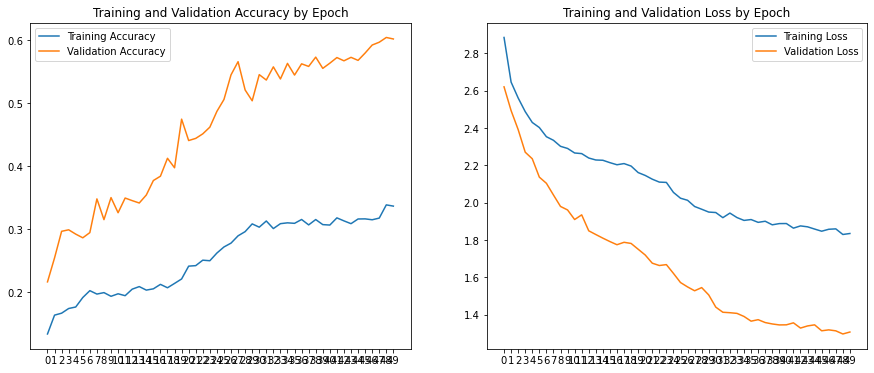

In [22]:
plot_results(history_1)

- Training accuracy at 0.96 while validation accuracy at 0.92. The first model seems to perform quite well and is not overfitting.
- Training loss follows a gradual descent while the validation loss seems to be increasing. This could be a sign of overfitting on the training data.

#### What is the Model Learning
Using an image of a broccoli, we can see what the CNN model is learning.

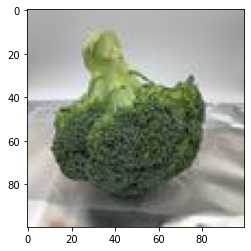

In [23]:
# Use unseen image of broccoli
pic = plt.imread('new_samples/image5.JPG')
plt.imshow(pic)
plt.show()

In [24]:
# Standardize and reshape image data to required format
test_image = (pic/255).reshape(1,100,100,3)

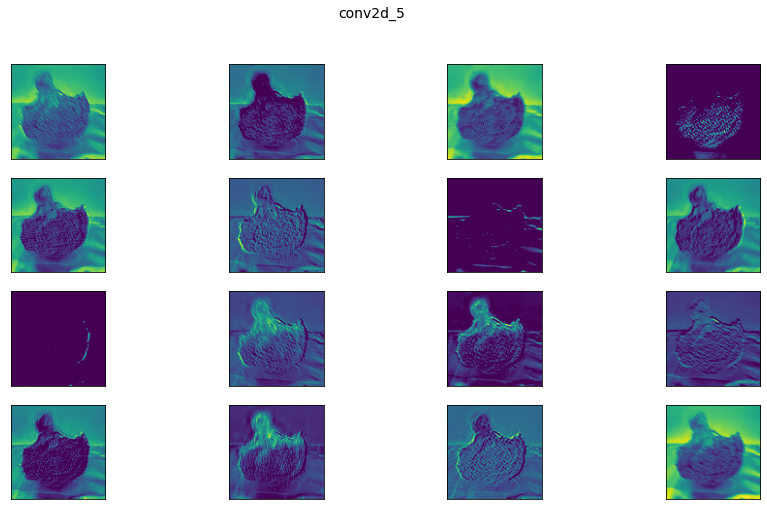

In [36]:
visualize_layer(model_1, 0, test_image)

The simple model does not seem to be learning much. Most of the filters in 1st layer is showing blank. Let's add one more convolutional layer with more filters to see if it improves the results. Also add an early stop layer to prevent the model from overfitting on the training data.

In [28]:
# Is this model able to predict correctly?
pd.Series(model_1.predict(test_image)[0], index=veg_pd.index).sort_values(ascending=False)[:3]

cucumber       0.091478
ginger         0.090457
cauliflower    0.089725
dtype: float32

#### 2nd Model - 2 x Conv2D Layers

In [43]:
np.random.seed(1)

# Instantiate a CNN
model_2 = tf.keras.models.Sequential()

# Add a convolutional layer.            
model_2.add(Conv2D(filters=32,
                 kernel_size=3, # height/width of filter
                 activation='relu',
                 input_shape=(100,100,3))) # shape of image

# Add a pooling layer
model_2.add(MaxPooling2D())

# Add a convolutional layer.
model_2.add(Conv2D(filters=32,
                 kernel_size=3,
                 activation='relu'))

# Add a pooling layer
model_2.add(MaxPooling2D())

# Flatten for fully connected NN
model_2.add(Flatten())

# Add a densely connected layer with 64 neurons.
model_2.add(Dense(64, activation='relu'))

model_2.add(Dropout(0.5))

# Add a densely connected layer with 13 neurons.
model_2.add(Dense(class_count, activation='softmax'))

model_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])

model_2.summary()

# Add checkpoint
checkpoint_2 = ModelCheckpoint("./models/best_model_2.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto')

history_2 = model_2.fit(X_train, y_train, batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    callbacks=[checkpoint_2],
                    verbose=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                1083456   
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)               

45/45 [==============================] - 49s 1s/step - loss: 0.2375 - accuracy: 0.9069 - val_loss: 0.5576 - val_accuracy: 0.9321

Epoch 00032: val_accuracy improved from 0.93137 to 0.93205, saving model to ./models\best_model_2.hdf5
Epoch 33/50
45/45 [==============================] - 49s 1s/step - loss: 0.2413 - accuracy: 0.9085 - val_loss: 0.5495 - val_accuracy: 0.9369

Epoch 00033: val_accuracy improved from 0.93205 to 0.93686, saving model to ./models\best_model_2.hdf5
Epoch 34/50
45/45 [==============================] - 48s 1s/step - loss: 0.2218 - accuracy: 0.9134 - val_loss: 0.5756 - val_accuracy: 0.9204

Epoch 00034: val_accuracy did not improve from 0.93686
Epoch 35/50
45/45 [==============================] - 51s 1s/step - loss: 0.2246 - accuracy: 0.9135 - val_loss: 0.6091 - val_accuracy: 0.9338

Epoch 00035: val_accuracy did not improve from 0.93686
Epoch 36/50
45/45 [==============================] - 48s 1s/step - loss: 0.2161 - accuracy: 0.9162 - val_loss: 0.5615 - val_accu

#### Results for 2nd Model

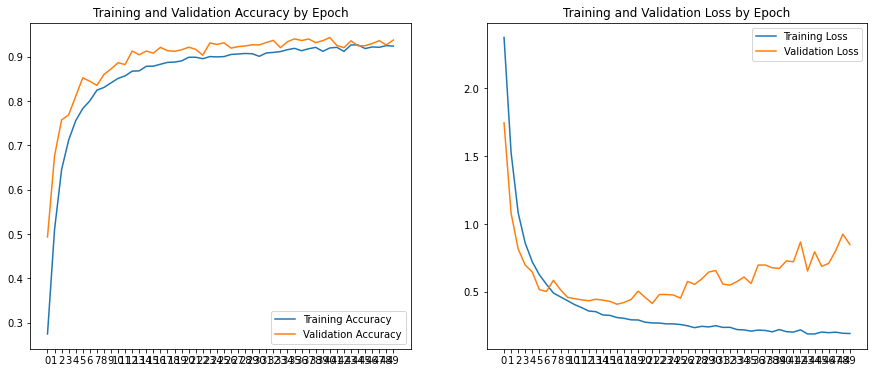

In [44]:
plot_results(history_2)

- The training stopped after 13 epochs with a Training accuracy of 0.937 and validation accuracy at 0.936. No sign of overfitting.
- Training loss follows a gradual descent while the validation loss fluctuates below 1.

#### Visualizing Convolutional Features of 2nd Model

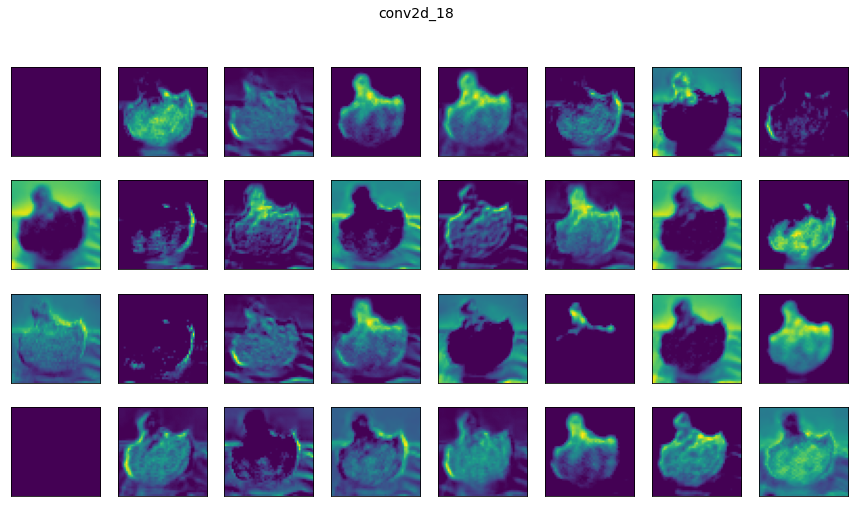

In [48]:
# Visualize the convolutional layer
visualize_layer(model_2, 2, test_image)

Even after adding more filters, most of the filters are showing blank. The model does not seem to be learning well.

In [49]:
pd.Series(model_2.predict(test_image)[0], index=veg_pd.index).sort_values(ascending=False)[:3]

broccoli    0.888633
cucumber    0.105846
pumpkin     0.005521
dtype: float32

The test image was predicted as broccoli in both models, with model 1 having a higher probability than model 2. Next, I will use transfer learning to see if the accuracy can be improved further.

### Use Transfer Learning from VGG16 with imagenet weights

In [150]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(100, 100, 3))  # 3 = number of channels in RGB pictures

In [151]:
# Check architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [152]:
datagen = ImageDataGenerator()
batch_size = 32

In [153]:
def extract_features(X, y, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count, class_count)) # 18 categories
    
    # generator = datagen.flow_from_directory(directory,
    #                                        target_size=(100,100),
    #                                        batch_size = batch_size,
    #                                        class_mode='binary')
    
    # Preprocess data
    generator = datagen.flow(X, y, batch_size=32)
    
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [154]:
# Extract features for train data
train_features, train_labels = extract_features(X_train, y_train, len(y_train))

In [155]:
# Extract features for test data
validation_features, validation_labels = extract_features(X_test, y_test, len(y_test))

In [160]:
np.random.seed(1)

# Define model
model_tl = Sequential()
model_tl.add(Flatten(input_shape=(3,3,512)))
model_tl.add(Dense(256, activation='relu', input_dim=(3*3*512)))
model_tl.add(Dropout(0.5))
model_tl.add(Dense(class_count, activation='softmax'))
model_tl.summary()

# Compile model
model_tl.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Add checkpoint
checkpoint_tl = ModelCheckpoint("./models/best_model_tl.hdf5", monitor='val_acc', verbose=1,
    save_best_only=True, mode='auto')

# Train model
history_tl = model_tl.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=[checkpoint_tl],
                    validation_data=(validation_features, validation_labels))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               1179904   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 18)                4626      
Total params: 1,184,530
Trainable params: 1,184,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
354/354 [==============================] - 4s 9ms/step - loss: 0.8313 - acc: 0.7484 - val_loss: 0.5013 - val_acc: 0.8771

Epoch 00001: val_acc improved from -inf to 0.87714, saving model to ./models\best_model_tl.hdf5
Epoch 2/100


354/354 [==============================] - 2s 7ms/step - loss: 0.0070 - acc: 0.9979 - val_loss: 0.6154 - val_acc: 0.9513

Epoch 00039: val_acc did not improve from 0.96465
Epoch 40/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0173 - acc: 0.9960 - val_loss: 0.7377 - val_acc: 0.9530

Epoch 00040: val_acc did not improve from 0.96465
Epoch 41/100
354/354 [==============================] - 2s 7ms/step - loss: 0.0051 - acc: 0.9986 - val_loss: 0.7471 - val_acc: 0.9554

Epoch 00041: val_acc did not improve from 0.96465
Epoch 42/100
354/354 [==============================] - 2s 7ms/step - loss: 0.0164 - acc: 0.9954 - val_loss: 1.1117 - val_acc: 0.9214

Epoch 00042: val_acc did not improve from 0.96465
Epoch 43/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0124 - acc: 0.9960 - val_loss: 0.4925 - val_acc: 0.9612

Epoch 00043: val_acc did not improve from 0.96465
Epoch 44/100
354/354 [==============================] - 3s 7ms/step - loss: 0.0086 - acc

#### Results for Transfer Learning Model

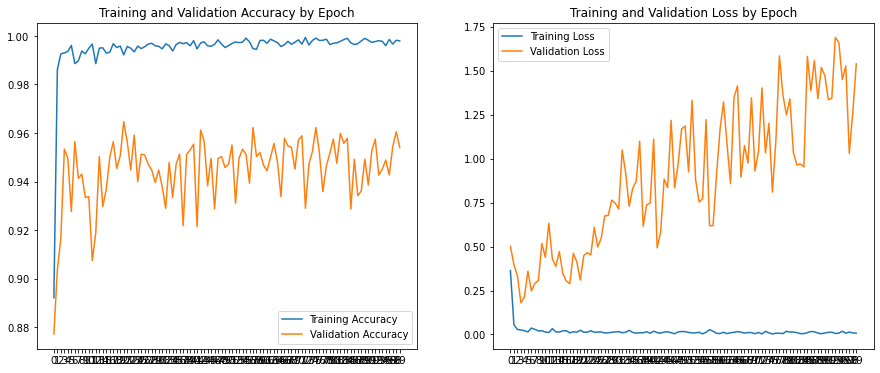

In [161]:
plot_results(history_tl)

#### Visualizing Convolutional Features of Transfer Learning Model

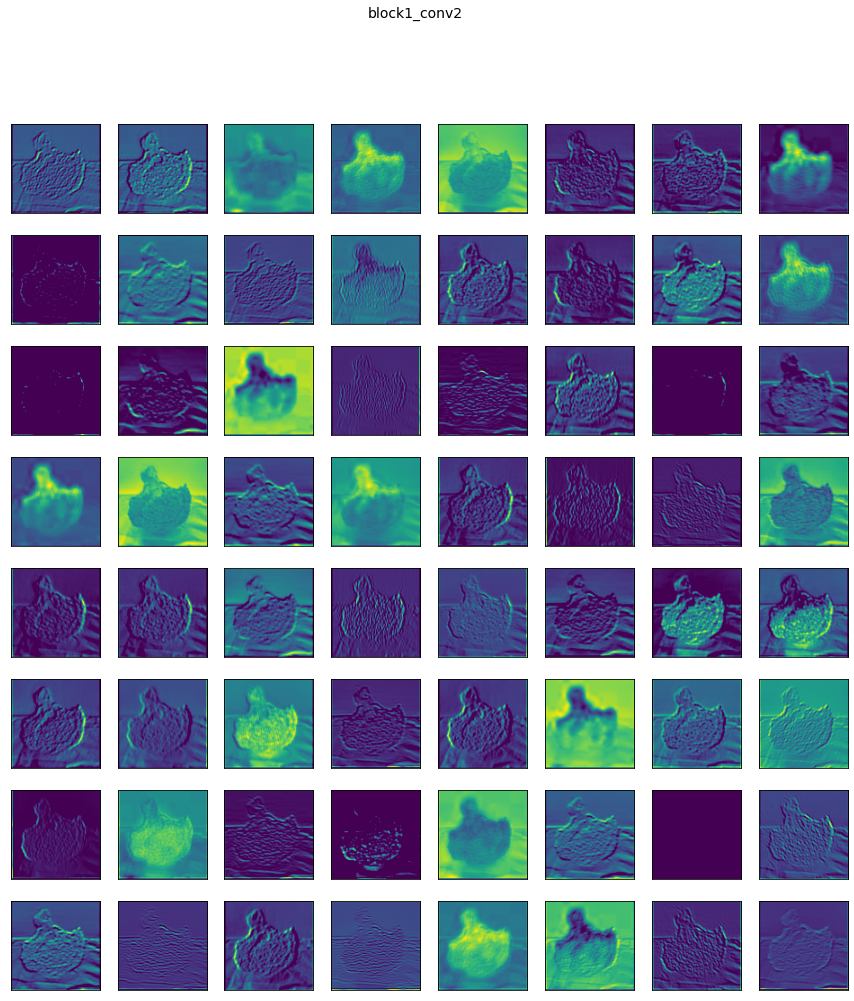

In [162]:
# Visualize the convolutional layer
visualize_layer(conv_base, 2, test_image)

The convolutional layer is showing much more details. The lastest model using VGG16 with imagenet weights has learned more about the images.

In [163]:
# How does the TL model perform with the test image?
features = conv_base.predict(test_image)
pd.Series(model_tl.predict(features)[0], index=veg_pd.index).sort_values(ascending=False)[:3]

broccoli        1.000000e+00
cauliflower     1.474320e-26
potato_sweet    5.068908e-33
dtype: float32

Accuracy on the test image has now increased to almost 100%.

## Model Evaluation
- With the VGG16 model, training accuracy was 1.0 while validation accuracy improved to 0.96.
- The visualization layers showed much more details, showing the model had learned more about the images.
- The model had the highest prediction accuracy of 100%.
- We will use the best transfer learning model as our production model.

In [165]:
# load production model
model_prod = load_model('./models/prod_model.hdf5')

### Classification Metrics
Next, we will look at misclassifications to understand which classes are getting misclassified and why. 

In [167]:
# Get the predictions, round off prediction results to 0 decimal for binary results
validation_preds = np.round(model_prod.predict(validation_features),0)

In [168]:
classification_metrics = classification_report(validation_labels, validation_preds, target_names=veg_pd.index)
print(classification_metrics)

                   precision    recall  f1-score   support

      cauliflower       1.00      1.00      1.00       274
             corn       1.00      0.65      0.79       150
         eggplant       1.00      0.94      0.97       156
        onion_red       0.99      1.00      0.99       605
      onion_white       0.73      0.98      0.84       146
       potato_red       1.00      0.95      0.98       151
     potato_sweet       1.00      0.91      0.95       150
     potato_white       0.97      0.98      0.97       275
           tomato       1.00      1.00      1.00       205
    tomato_yellow       1.00      1.00      1.00       153
      bittergourd       1.00      1.00      1.00        88
          pumpkin       0.83      1.00      0.90        90
      white_gourd       0.99      0.97      0.98        70
         broccoli       1.00      1.00      1.00       140
         cucumber       0.97      0.98      0.98        63
cucumber_japanese       0.89      1.00      0.94       

Corn has a very low recall score of 0.65 while onion_white has the lowest precision of 0.73. Let's look at the confusion matrix to see what corn and onion_white are being misclassified as.

### Confusion Matrix

In [169]:
# Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
# Basically, flipping a dummy variable back to it’s categorical variable
categorical_test_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(validation_preds).idxmax(axis=1)

cm = confusion_matrix(categorical_test_labels, categorical_preds)

In [170]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

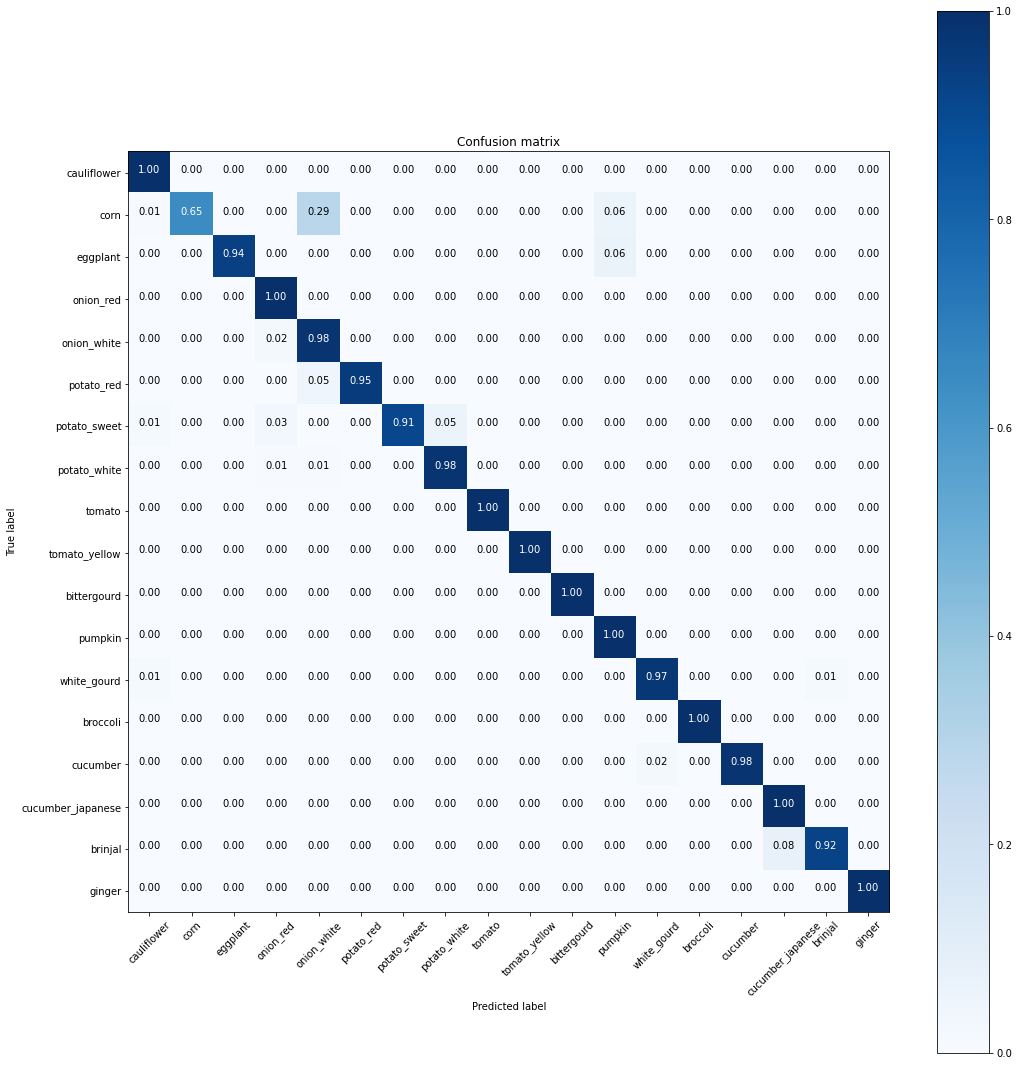

In [171]:
plot_confusion_matrix(cm, veg_pd.index, normalize=True)

Most of misclassifications for corn was as onion_white, which also affected the precision of onion_white. Let's look at some of the corn images to see if there are obvious reasons for the misclassification to onion_white.

### Misclassification Analysis

In [439]:
corn_df = test[test['code']==1]
onion_white_df = test[test['code']==4]

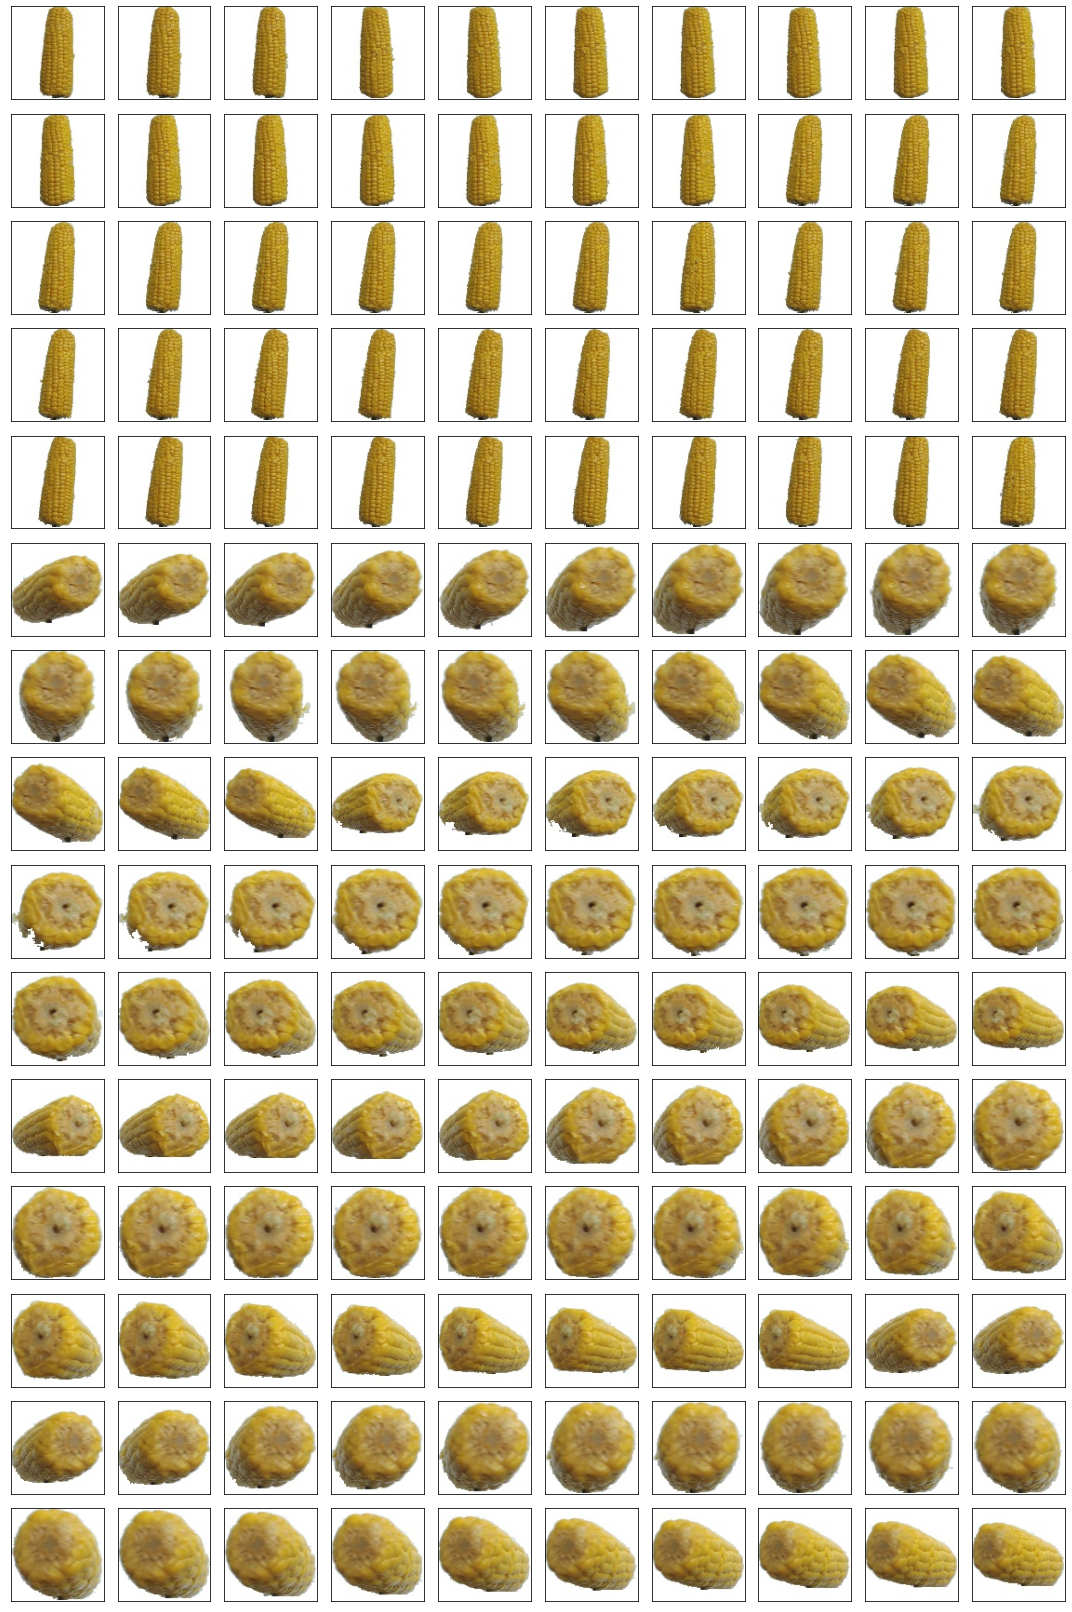

In [354]:
# Show all corn images used for validation
plot_images(images=corn_df['image'].values,names="",cols=10,suptitle="")

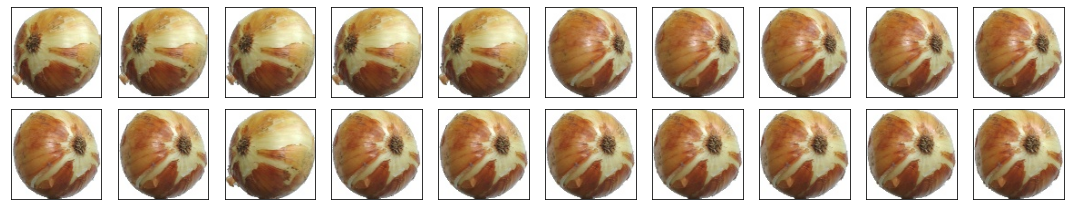

In [448]:
# Show some onion white images used for validation
plot_images(images=onion_white_df.iloc[100:120,1].values,names="",cols=10,suptitle="")

Looks like quite a number of the corn images were top view and did not really look like corn actually. The light yellowish colour would have contributed to their misclassification as onion_white.

### More Test Images

Let's try the production model with a few more test images.

In [437]:
# Load images from new_samples folder
import_dir = "./new_samples/"
size = (100,100)
new_images = []
for name in glob.glob(import_dir + '*.jpg'):
    
    img = Image.open(name)
    
    # remove all the exif tags except for the one that contains the orientation information (0x0112)
    exif = img.getexif()

    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    # Put the new exif object in the original image
    new_exif = exif.tobytes()
    img.info["exif"] = new_exif

    img = ImageOps.exif_transpose(img)
    img = ImageOps.autocontrast(img)
    
    # Check that the image is of size 100x100, if not resize to 100x100
    if img.size != size:
        pic = ImageOps.fit(img, size, Image.ANTIALIAS)
    else:
        pic = img
    
    # Convert image to numpy array with values between 0 and 1
    pic = np.array(pic)
    new_images.append(pic/255)

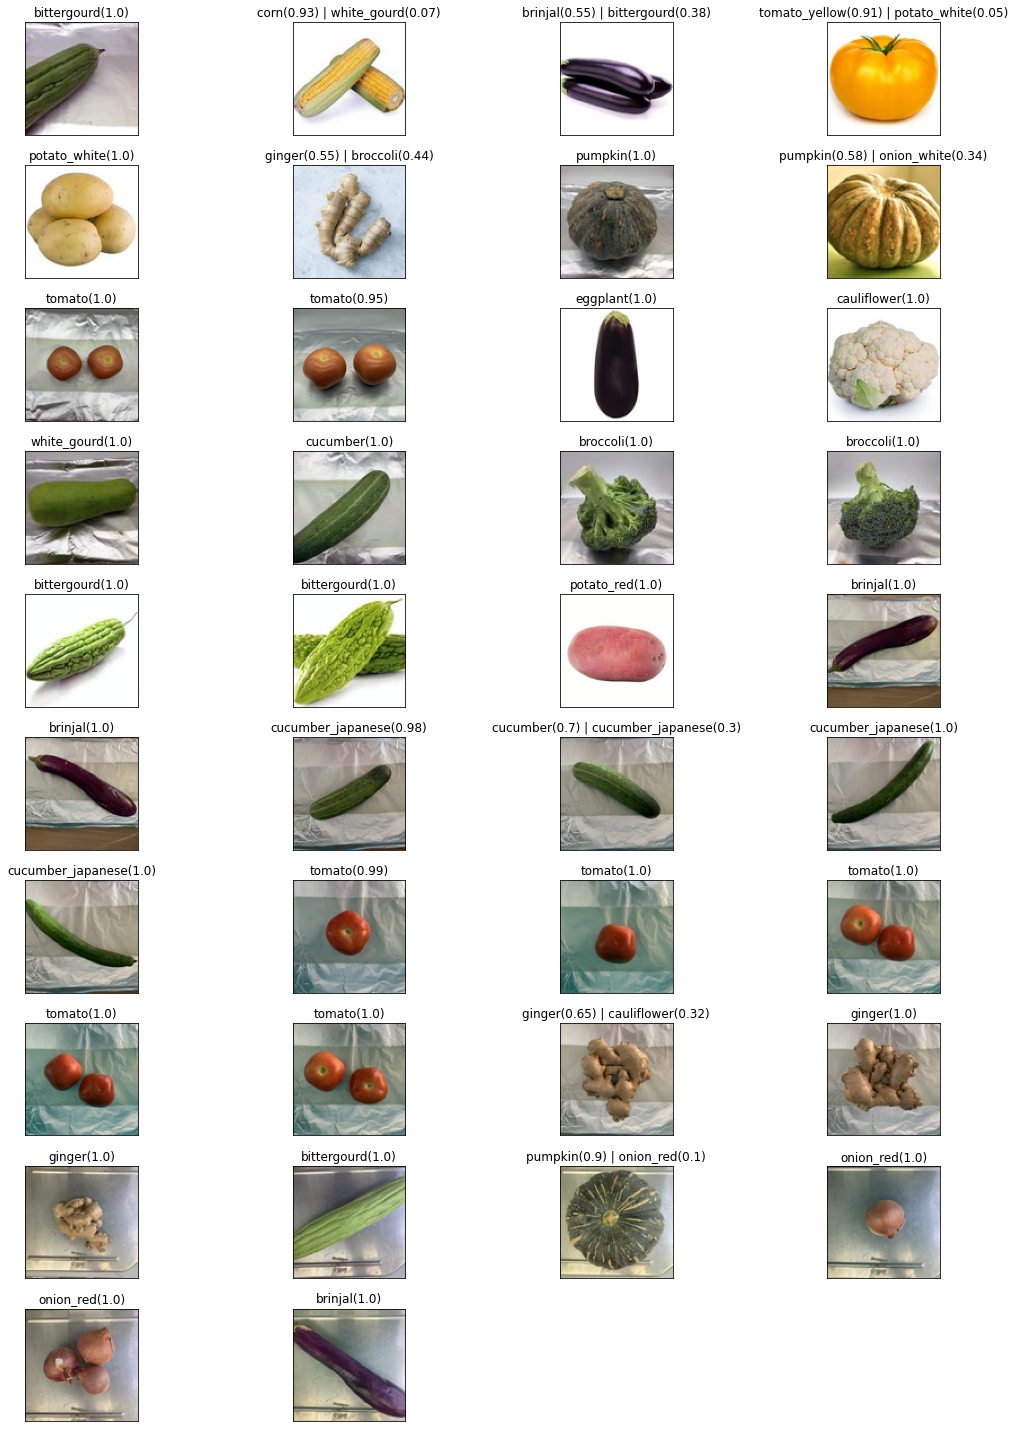

In [438]:
rows = int(np.ceil(len(new_images)/4))
fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(15,rows*2))
ax = axes.ravel()
to_hide = len(ax) - len(new_images)

for index in range(len(new_images)):
    new_image = new_images[index].reshape(1,100,100,3)
    
    # Extract features using VGG16 model
    features = conv_base.predict(new_image)
    
    # Predict with the production model
    pred = pd.Series(model_tl.predict(features)[0], index=veg_pd.index).sort_values(ascending=False)[:2]
    
    # Show top prediction, or top-2 predictions if top prediction's probability is <95% 
    if pred.values[0] > 0.95:
        label = pred.index.values[0] + "(" + str(np.round(pred.values[0],2)) + ")"
    else:
        label = pred.index.values[0] + "(" + str(np.round(pred.values[0],2)) + ")" \
                + " | " + pred.index.values[1] + "(" + str(np.round(pred.values[1],2)) + ")"

    ax[index].imshow(new_images[index])
    ax[index].set_title(label)
    ax[index].set_xticks([])
    ax[index].set_yticks([])

if to_hide>0:        
    for index in range(1, to_hide+1): 
        ax[-index].set_visible(False)
        
plt.tight_layout()
plt.show()

Out of 38 test images, 1 was predicted wrongly and 2 had low probabilities close to 0.5. 
1. A cucumber was predicted as japanese cucumber. This is probably due to the high resemblance between the 2 vegetables.
    - **Solution:** Vegetables known to resemble each other can be shown as additional options for the consumer to select from.


2. The ginger was predicted with only 55% probability, with 47% probability it could be broccoli. The pumpkin was predicted with 58% probability, with 34% probability it could be white onion.
    - **Solution:** We can provide top-2 predictions as options for the customer to select from.<br><br>

## Conclusion

- The production model has a high validation accuracy of **0.964**.<br><br>
- Even though the model was trained using single item images, it is able to predict accurately even when more than 1 item was placed.<br><br>
- Misclassification might happen when the vegetable resembles another vegetable.
    - eg. 1: The top view of corn that was misclassified as white onion.
    - eg. 2: Cucumber misclassified as Japanese cucumber
<br><br>
- Images used for training the model do not need to have white backgrounds. A gray background is more ideal for this case since it more closely resembles the supermarket setup while providing the contrast needed against the vegetable to enable the model to learn.

## Recommendations

- Top-2 predictions should be shown for the customer to choose from instead of showing only the top prediction<br><br>
- Vegetables which are very similar to another class should also include the other similar class for the customer to choose from<br><br>
- The weighing scale should be placed in a well-lit location so that images taken has enough contrast for more accurate predictions.

## Adding More Classes in Future

- To add new classes, the model will need to be re-trained with images of the new class<br><br>
- Recommendations for new class images:<br><br>
    - Image can be taken with a grey background.<br><br>
    - There should have at least 30 basic images for training and 10 basic images for validation<br><br>
    - Each basic image can be augmented using rotation (0 to 360 degrees, in increments of 10 degrees for training and 36 degrees for validation) and filled in with grey to match the background<br><br>
    - There should be a total of around 600 training images and 100 validation images for each class<br><br>
- Two files should be updated with the new classes:<br>
    1. veg_class.pkl - This pickle contains the full list of classes
    2. model_prod.tf - This folder contains the production model to be used for prediction